## Determinate the failed build suqueces

For more information about the underlaying data visit [Travis Torrent](https://travistorrent.testroots.org)

In [61]:
# Import the data set via dask => runs a lot faster than with pandas
import dask.dataframe as dd

org = dd.read_csv('travistorrent_11_1_2017.csv', blocksize=25000000, usecols=['tr_build_id', "tr_prev_build", "tr_status"])
org.set_index('tr_build_id')
org.compute()

,tr_build_id,tr_prev_build,tr_status
0,106060,105310.0,passed
1,106060,105310.0,passed
2,106060,105310.0,passed
3,106060,105310.0,passed
4,106060,105310.0,passed
5,106060,105310.0,passed
6,106060,105310.0,passed
7,106060,105310.0,passed
8,106060,105310.0,passed
9,106060,105310.0,passed


In [12]:
import dask.dataframe as dd

# Load data, set index 
df = dd.read_csv('travistorrent_11_1_2017.csv', blocksize=25000000, 
                 usecols=['tr_build_id', "tr_prev_build", "tr_status", "git_prev_built_commit"])
df = df.compute()
df.set_index('tr_build_id')
df = df[df.tr_build_id.notnull()] # To be sure

# Find all passed builds ids (=> check whether all jobs really passed)
# Map the failed status to 1 and all other to 0
def check_if_passed(df):
    if df.tr_status == 'passed':
        df.tr_status = 0
    else:
        df.tr_status = 1
    return df

maped_status = df.apply(check_if_passed, axis=1)

# Get all passed builds
grouped_build_id = maped_status.groupby(['tr_build_id']).tr_status.sum()
grouped_build_id = grouped_build_id.where(lambda x: x ==  0 ).dropna()

passed_builds_all = df.where(lambda x: x.tr_build_id.isin(grouped_build_id.keys().values))
passed_builds = passed_builds_all[passed_builds_all.tr_prev_build.notnull()]
passed_builds_all.count()
passed_builds.count()

tr_build_id              1720209
git_prev_built_commit    1720209
tr_prev_build            1720209
tr_status                1720209
dtype: int64

In [24]:
#passed_builds[passed_builds.tr_status == 'failed'].head(1000)
#passed_builds_all.to_csv("passed_builds_all_out.csv")
passed_builds.count()

tr_build_id              1720209
git_prev_built_commit    1720209
tr_prev_build            1720209
tr_status                1720209
dtype: int64

In [188]:
# Get all passed builds where the prev build failed
passed_whith_prev_failed = passed_builds.where(lambda x: x.tr_prev_build.isin(grouped_build_id.keys().values) == False)
passed_whith_prev_failed.count()

tr_build_id              267156
git_prev_built_commit    267156
tr_prev_build            267156
tr_status                267156
dtype: int64

In [35]:
passed_whith_prev_failed[passed_whith_prev_failed.tr_prev_build == 106176].head(1000)

,tr_build_id,git_prev_built_commit,tr_prev_build,tr_status
181,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
182,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
183,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
184,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
185,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
186,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
187,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
188,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
189,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed
190,108038.0,cfe7548aef1b005e49eacd8b0177764e77643ccf,106176.0,passed


In [104]:
# Load data via pandas to reference it
import pandas

data_frame = pandas.read_csv("travistorrent_11_1_2017.csv", usecols=[i for i in range(61) if i not in (3,6,18)])

In [175]:
# Determine all failed prev for each starting point (passed with prev failed)

# Helper to find relevant data
def get_build_rows_by_build_id(tr_build_id):
    return data_frame[data_frame.tr_build_id==tr_build_id]
    
# Result arr with custom data structure, contains the build id and the
results = dict()
def search_for_prev_builds(row): # Determine all failed preds for a specific starting print
    #if len(results) > 100000:
    #    return
    if (row.tr_build_id in results.keys()):
        #print("Wrong state for build id {0}".format(row.tr_build_id))
        return
    if not row.tr_build_id > 0: #nan
        return

    results[row.tr_build_id] = [] # List of previous builds
    # 126229 => 117642 (errored)
    # 117642 => 117385 (errored)
    # 117385 => NaN
    current_prev_build_id = row.tr_prev_build
    while(current_prev_build_id > 0):
        prev_build_rows = get_build_rows_by_build_id(current_prev_build_id)
        results[row.tr_build_id].append({"build_id": current_prev_build_id, "builds": prev_build_rows})
        if(prev_build_rows.tr_prev_build.count() > 0): # any content?
            base_row = prev_build_rows.head(1)
            if base_row.tr_status.values[0] == "passed":
                return row
            current_prev_build_id = base_row.tr_prev_build.values[0]
        else:
            return row
    return row

result_data = passed_whith_prev_failed[passed_whith_prev_failed.tr_prev_build.notnull()]
#result_data = result_data[result_data.tr_build_id == 126229]
result_data.apply(search_for_prev_builds, axis=1)
"done"


'done'

In [187]:
out = result_data.tr_build_id.unique()
print(len(out))
print(len(results))

42673
42673


In [384]:
# Top failed builds in row
for key, value in results.items():
    if len(value) > 150:
        print(key, " => ", len(value), ": ", value[0]['builds'].head(1).gh_project_name.values[0])

147719922.0  =>  1562 :  apache/sling
118003704.0  =>  177 :  facebook/buck
779485.0  =>  171 :  ruby/ruby
72443122.0  =>  286 :  apache/jackrabbit-oak
140087226.0  =>  242 :  facebook/buck
94335879.0  =>  615 :  apache/drill
107834715.0  =>  486 :  orbeon/orbeon-forms
74140385.0  =>  284 :  orbeon/orbeon-forms


## Build sequences per lenght 

[8554, 21211, 12077, 791, 25, 7, 7, 1]
Populating the interactive namespace from numpy and matplotlib


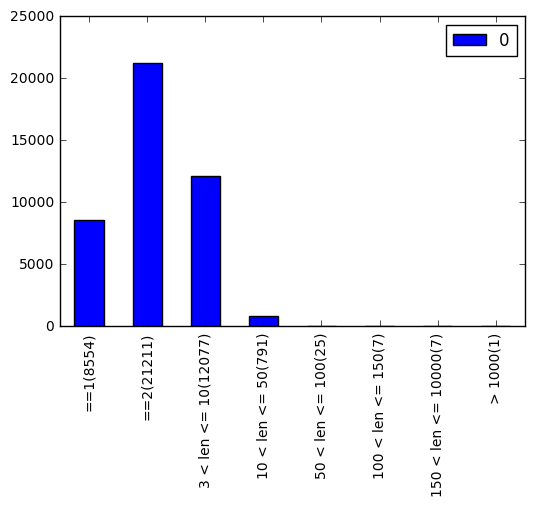

In [458]:
# Show length of failed builds
counter = [0, 0, 0, 0, 0, 0, 0, 0]
for key, value in results.items():
    if len(value) > 1000:
        counter[7] += 1
    elif len(value) > 150:
        counter[6] += 1
    elif len(value) > 100:
        counter[5] += 1
    elif len(value) > 50:
        counter[4] += 1
    elif len(value) > 10:
        counter[3] += 1
    elif len(value) > 2:
        counter[2] += 1
    elif len(value) > 1:
        counter[1] += 1
    elif len(value) > 0:
        counter[0] += 1
counter
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
print(counter)
index_str = "==1({}),==2({}),3 < len <= 10({}),10 < len <= 50({}),50 < len <= 100({}),100 < len <= 150({}),150 < len <= 10000({}),> 1000({})".format(
    counter[0], counter[1], counter[2], counter[3], counter[4], counter[5], counter[6], counter[7])
index = index_str.split(",")

counter = np.int_(counter)
%pylab inline


len_failed_builds = DataFrame(data=counter, index=index)
plt.figure()
len_failed_builds.plot(kind='bar')


## Longest time of a sequence 

In [411]:
#results[147719922.0][0]['builds'].head(1).gh_build_started_at.values[0]
#results[147719922.0][0]['builds'].head(1).gh_build_started_at.values[0]

dt_end = data_frame[data_frame.tr_build_id == 147719922].head(1).gh_build_started_at.values[0] #green
dt_start = results[147719922.0][1561]['builds'].head(1).gh_build_started_at.values[0]
import datetime
print(dt_end, dt_start)
delta = datetime.datetime(2016,7,27,10,34,49) - datetime.datetime(2015,12,17,17,58,40)

print(dt_start)
delta = datetime.datetime.strptime(dt_end, "%Y-%m-%d %H:%M:%S") - datetime.datetime(2015,12,17,17,58,40)
delta.days


delta = datetime.datetime.strptime(dt_start, "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(dt_end, "%Y-%m-%d %H:%M:%S")
delta.days           

2016-07-27 10:34:49 2015-12-17 17:58:40
2015-12-17 17:58:40


-223

## Prepare data 

In this section we perform some calculations on the result array to prepare the import into a panda data frame 

In [469]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

counter_detail = []
for key, values in results.items():
    if len(values) > 0:
        num_failed_builds = len(values)
        team_size = 0
        num_tests_ok = 0
        num_tests_run = 0
        num_tests_min_ok = 100000 
        for value in values: 
            team_size += value['builds'].gh_team_size.mean()
            num_tests_ok += value['builds'].tr_log_num_tests_ok.mean()
            current_min = value['builds'].tr_log_num_tests_ok.mean()
            num_sloc = value['builds'].gh_sloc.mean()
            num_test_deleated =  value['builds'].gh_diff_tests_deleted.mean()
            if current_min < num_tests_min_ok: 
                num_tests_min_ok = current_min
            num_tests_run += value['builds'].tr_log_num_tests_run.mean()
        
        team_size = team_size / len(values)
        num_tests_ok = num_tests_ok / len(values)
        num_tests_run = num_tests_run / len(values)
        num_sloc = num_sloc / len(values)
        num_test_deleated 
        if num_tests_run > 0:
            test_ok_percent = num_tests_ok / num_tests_run * 100
        else:
            test_ok_percent = 0
            
        first = values[-1]
        num_first_test_ok = first['builds'].tr_log_num_tests_ok.mean()
        delta = num_first_test_ok - num_tests_min_ok
        last = values[0]
        last_start_dates = last["builds"].gh_build_started_at.values
        first_start_dates = first["builds"].gh_build_started_at.values
      
        if len(values[0]['builds'].gh_project_name.values) > 0:
            project_name = values[0]['builds'].gh_project_name.values[0]
        
        if len(last_start_dates)  > 0 and len(first_start_dates) > 0: 
            
            num_duration_days = datetime.datetime.strptime(last_start_dates[0], "%Y-%m-%d %H:%M:%S") - datetime.datetime.strptime(first_start_dates[0], "%Y-%m-%d %H:%M:%S")
            num_duration_days = num_duration_days.days
        if num_first_test_ok > 0:
            test_ok_delta_percent = delta / num_first_test_ok  * 100 
        else:
            test_ok_delta_percent = 0
        counter_detail.append((num_failed_builds, team_size, num_tests_ok, num_tests_run, test_ok_percent,test_ok_delta_percent,num_duration_days,num_sloc,num_test_deleated,project_name))
                
            

In [470]:
            
%pylab inline
count_per_project = DataFrame(data=counter_detail,
    columns=["num_failed_builds", "team_size", "num_tests_ok", "num_tests_run", "test_ok_percent", "test_ok_delta_percent", "num_duration_days","num_sloc", "num_test_deleated", "porject_name"])
#count_per_project = count_per_project.groupby("team_size")


Populating the interactive namespace from numpy and matplotlib


## Projects that contains sequences > 150 days open 

In [461]:
one_day_count = 0
for detail in counter_detail:
    if detail[6] > 500:
        print(detail[6], " days ", detail[-1])
    if detail[6] < 1:
        one_day_count += 1
print("Green within one day: ", one_day_count)

584  days  assaf/vanity
561  days  codez/dry_crud
561  days  codez/dry_crud
513  days  guard/guard-spork
912  days  nbudin/devise_cas_authenticatable
912  days  nbudin/devise_cas_authenticatable
549  days  morgoth/picasa
549  days  morgoth/picasa
637  days  apache/drill
730  days  mongoid/origin
572  days  lodge/lodge
621  days  marubinotto/Piggydb
Green within one day:  29257


## Percentage of passed tests vs lenght of a sequence 

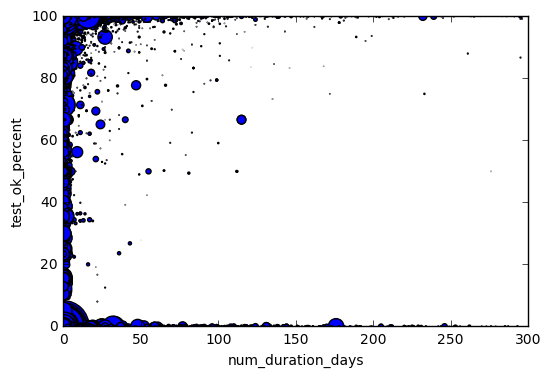

In [488]:
    count_per_project.plot(x="num_duration_days", y ="test_ok_percent", s=count_per_project["num_sloc"]/1000,kind="scatter", xlim=(0, 300), ylim=(0, 100))

In [ ]:
## Team size vs number of builds in a sequence 

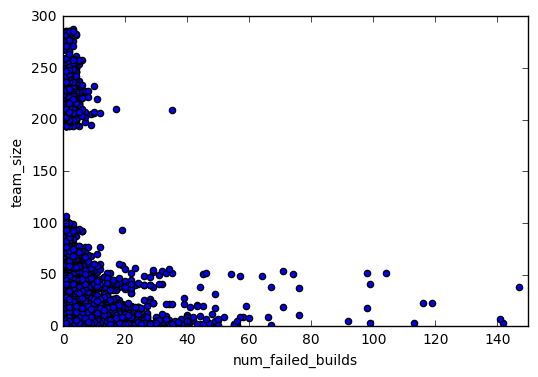

In [463]:
count_per_project.plot(x="num_failed_builds", y ="team_size",kind="scatter", xlim=(0, 150), ylim=(0, 300))

## Number of failed builds in a sequence vs the maximum deterioration of test results 

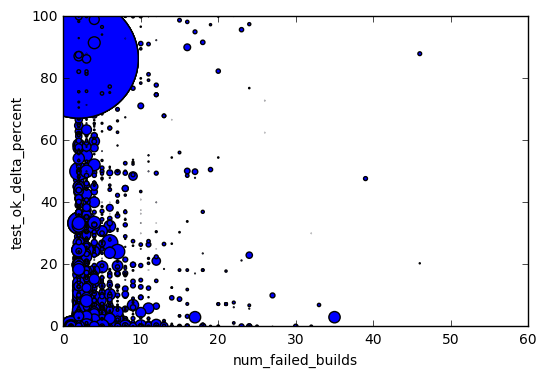

In [468]:
count_per_project.plot(x="num_failed_builds", y ="test_ok_delta_percent", s=count_per_project["num_tests_run"]/100,kind="scatter", xlim=(0, 60), ylim=(0, 100))